# Image Filtering

## Import the necessary packages

In [1]:
# Import the required modules
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
from PIL import Image
from skimage import data
import scipy
import cv2
# from IPython.html.widgets import interact, fixed
from ipywidgets import interact, fixed, FloatSlider, IntSlider,FloatRangeSlider, Label

# Image Filters
* Filtering an image means replacing each pixel in the original image with a linear combination of that pixel and its neighbors.
* The filter “template” or “kernel” or “mask” $H[u,v]$ is the values for the weights in the linear combination.
* Assuming the kernel size is 2k+1 by 2k+1 and the center element is element (0,0):
$$\large g(i,j) = \sum\limits_{u =  - k}^{k} {\sum\limits_{v =  - k}^{k} {h(u,v)f(i +u,j +v)} }   $$

## Convolution 
Convolution is the same as correlation except the mask (also known as **kernel**, or **template**, or **filter**) is flipped both horizontally and vertically. Notice that in convolution you can either flip the mask or flip the original image.

$$\large g(i,j) = \sum\limits_{u =  - k}^{k} {\sum\limits_{v =  - k}^{k} {h(u,v)f(i - u,j - v)} }   $$

**Notes:**
* Convolution between the two function $f$ and $h$ is usually shown as  $g=f*h$  where $*$ means convolution.
* If the kernel is symmetric around the center then correlation and convolution are the same


In simple terms, 
    
    Assume that the center of the kernel is positioned over a specific pixel (p), in an image.
    Then multiply the value of each element in the kernel (1 in this case), with the corresponding pixel element (i.e. its pixel intensity) in the source image.
    Now, sum the result of those multiplications and compute the average.
    Finally, replace the value of pixel (p), with the average value you just computed.

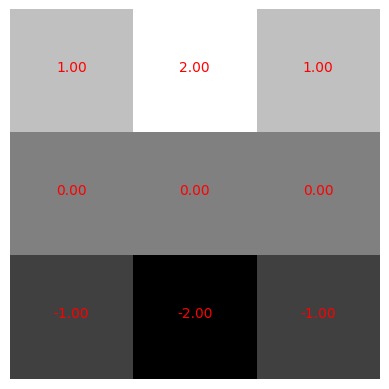

In [2]:
kernel = np.array([[ 1., 2, 1],[0, 0, 0],[-1, -2, -1]])
kernel_sum = np.sum(kernel)
kernel = kernel/kernel_sum if kernel_sum else kernel
plt.rcParams['image.interpolation'] = 'none'
plt.imshow(kernel, cmap=plt.cm.gray);
plt.axis('off')
for row in range(np.shape(kernel)[0]):
    for col in range(np.shape(kernel)[1]):
        plt.text(col,row,'{:0.2f}'.format(kernel[row][col]),ha='center',color='red')
plt.show()

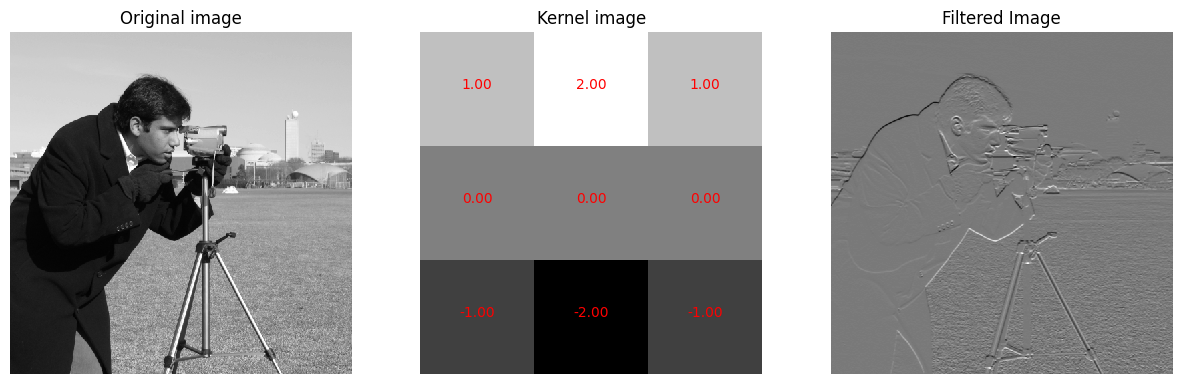

In [3]:
from scipy.ndimage import convolve
plt.rcParams['image.interpolation'] = 'none'
def convolve_two_images_and_display_the_results(kernel,original_image):
    # Normalize the kernel
    kernel_sum=abs(np.sum(kernel))
    kernel= kernel/kernel_sum if kernel_sum else kernel
    filtered_image = scipy.ndimage.convolve(original_image, kernel)
    fig1, axes_array = plt.subplots(1, 3)
    fig1.set_size_inches(15,5)
    image_plot = axes_array[0].imshow(original_image ,cmap=plt.cm.gray) # Show the original image
    axes_array[0].axis('off')
    axes_array[0].set(title='Original image')
    image_plot = axes_array[1].imshow(kernel,cmap=plt.cm.gray) # Show the kernel
    for row in range(np.shape(kernel)[0]):
        for col in range(np.shape(kernel)[1]):
            axes_array[1].text(col,row,'{:0.2f}'.format(kernel[row][col]),ha='center',color='red')
    axes_array[1].axis('off')
    axes_array[1].set(title='Kernel image')
    #print(filtered_image);
    image_plot = axes_array[2].imshow(filtered_image,cmap=plt.cm.gray) # Limit the range
    axes_array[2].axis('off')
    axes_array[2].set(title='Filtered Image')
    plt.show()
    
kernel = np.array([[ 1.,  2,  1],[ 0,  0,  0],[-1, -2, -1]])
original_image = data.camera()/255.
convolve_two_images_and_display_the_results(kernel,original_image)


## Image smoothing
If we select a kernel which calculates the average of pixels around the center then this kernel has the effect of smoothing the picture. Note that if we increase the size of the kernel then the image will be smoother.

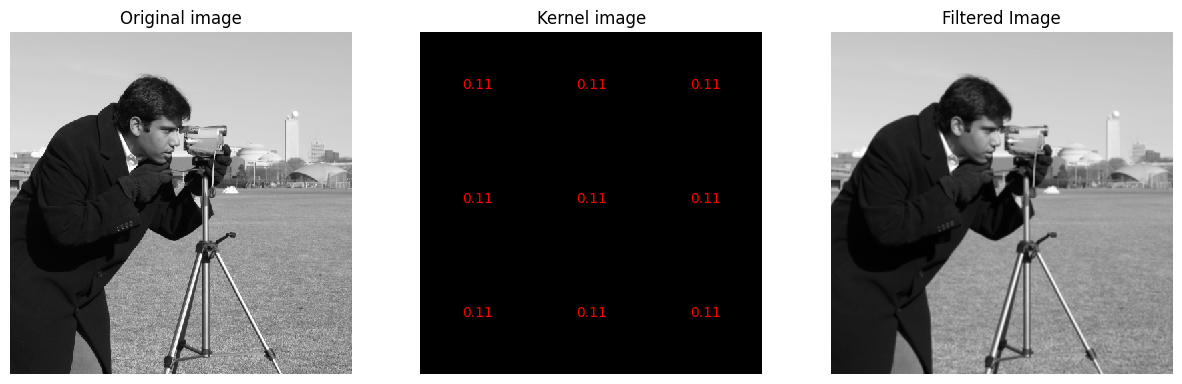

interactive(children=(IntSlider(value=3, description='kernel_size', max=51, min=1, step=2), Output()), _dom_cl…

In [4]:
def demo_kernel_size(original_image,kernel_size=3):
    kernel = np.ones((kernel_size,kernel_size));
    convolve_two_images_and_display_the_results(kernel,original_image);
current_image = data.camera()/255.0;
interact(demo_kernel_size,original_image=fixed(current_image),
         kernel_size=IntSlider(min=1, max=51., step=2,value=3));

As you can see the kernel basically finds the average of all the pixels around the center pixel. What if we like to give higher weights to the pixels which are closer to the center pixel? In that case we can define a function which gets smaller as it gets away from the center. One such function is the Gaussian function. 

$$\large f(x) = \frac{1}{{\sqrt {2\pi{\sigma ^2} } }}\;{e^{ - \frac{{{{(x - \mu )}^2}}}{{2{\sigma ^2}}}}}$$

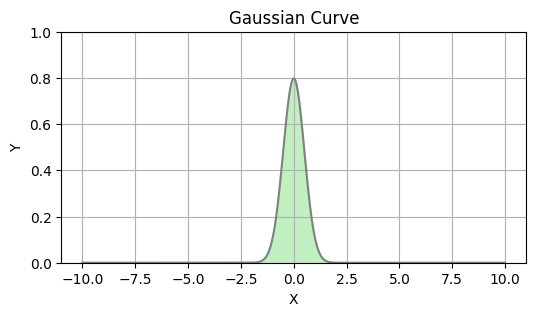

interactive(children=(FloatSlider(value=0.0, description='mean', max=10.0, min=-10.0), FloatSlider(value=0.5, …

In [5]:
def display_1d_gaussian(mean=0.0,sigma=0.5):
    x =np.linspace(-10,10,1000)
    y = (1/np.sqrt(2*np.pi*sigma**2))*np.exp(-((x-mean)**2)/(2*sigma**2))
    fig, axes1 = plt.subplots(1, 1)
    fig.set_size_inches(6,3)
    axes1.set(xlabel="X",ylabel="Y",title='Gaussian Curve',ylim=(0,1))
    plt.grid(True)
    axes1.plot(x,y,color='gray')
    plt.fill_between(x,y,0,color='#c0f0c0')
    plt.show()
interact(display_1d_gaussian,mean=FloatSlider(min=-10., max=10., step=0.1),
        sigma=FloatSlider(min=0.1, max=10, step=0.1, value=0.5));

Let's create a two dimensional Gaussian kernel.


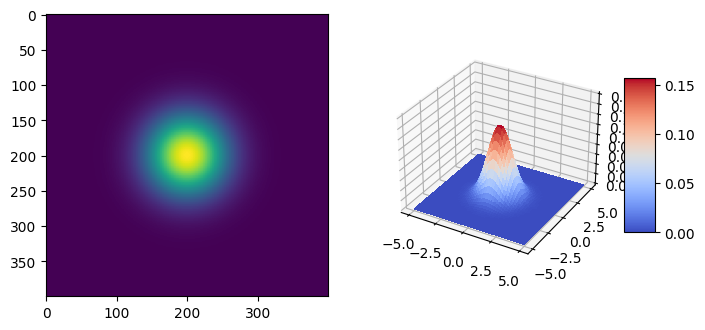

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='sigma', max=3.0, min=1.0, s…

In [6]:
import scipy.stats
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
def display_gaussian_kernel(sigma=1.0):
    X = np.linspace(-5, 5, 400)
    Y = np.linspace(-5, 5, 400)
    X, Y = np.meshgrid(X, Y)
    R = np.sqrt(X**2 + Y**2)
    Z = np.sin(R)
    mu = np.array([0.0, 0.0])
    covariance = np.diag(np.array([sigma, sigma])**2)
    XY = np.column_stack([X.flat, Y.flat])
    z = scipy.stats.multivariate_normal.pdf(XY, mean=mu, cov=covariance)
    Z = z.reshape(X.shape)

    # Plot the surface.
    fig = plt.figure()
    fig.set_size_inches(8,4)
    ax1 = fig.add_subplot(121)
    ax1.imshow(Z)
    ax2 = fig.add_subplot(122, projection='3d')

    # fig = plt.figure()
    # ax = fig.gca(projection='3d')
    # axes_array[0].set(projection='3d')
    surf = ax2.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm,
                           linewidth=0, antialiased=False)
    # Customize the z axis.
    ax2.set_zlim(0, .2)
    ax2.zaxis.set_major_locator(LinearLocator(10))
    ax2.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
interact(display_gaussian_kernel,sigma=FloatSlider(min=1, max=3, step=0.05,value=1.0,continuous_update=False));

The <tt class="docutils literal"><span class="pre">scipy</span></tt> module has <tt class="docutils literal"><span class="pre">scipy.ndimage.filters.gaussian_filter</span></tt> which will generate the convolution of an image with  a 2d Gaussian filter.

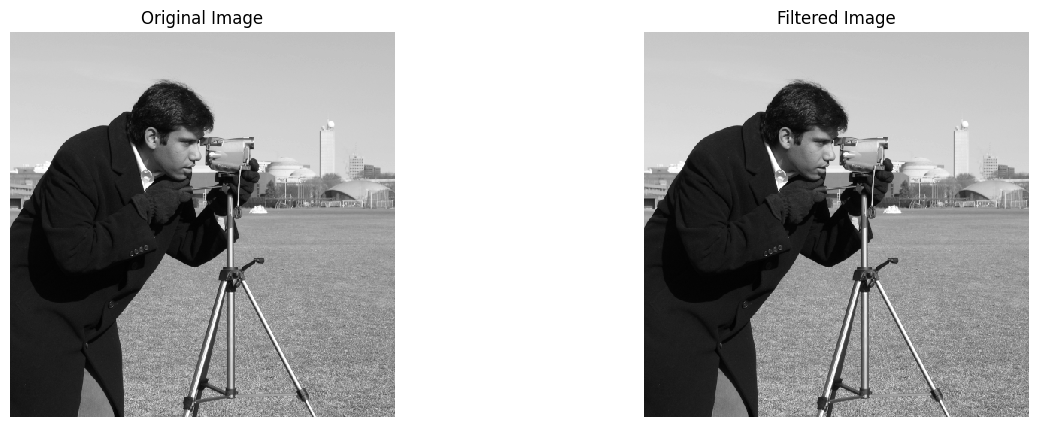

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='sigma', max=10.0), Output()…

In [7]:
def gaussian_filter_and_display_results(original_image, sigma):
    # kernel2 = np.ones((5, 5), np.float32) / 25
    # filtered_image = cv2.filter2D(src=original_image, ddepth=-1, kernel=kernel2)
    filtered_image=scipy.ndimage.gaussian_filter(original_image, 
            sigma=sigma, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)
    fig1, axes_array = plt.subplots(1, 2)
    fig1.set_size_inches(15,5)
    image_plot = axes_array[0].imshow(original_image,cmap=plt.cm.gray) 
    axes_array[0].axis('off')
    axes_array[0].set(title='Original Image')
    image_plot = axes_array[1].imshow(filtered_image,cmap=plt.cm.gray)
    axes_array[1].axis('off')
    axes_array[1].set(title='Filtered Image')
    plt.show()

current_image = data.camera()/255.
interact(gaussian_filter_and_display_results,original_image=fixed(current_image),
         sigma=FloatSlider(min=0.0, max=10, step=0.1,continuous_update=False));

You can sharpen an image by subtracting a blurred image from original

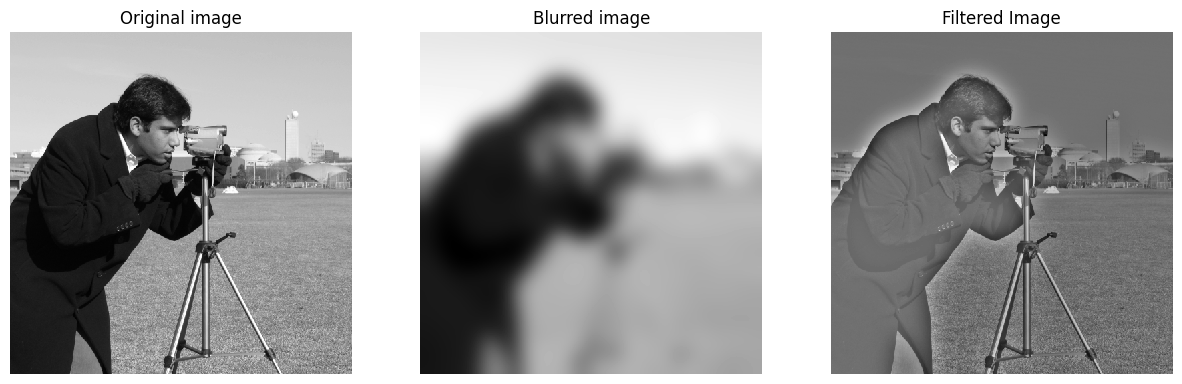

In [8]:
original_image = data.camera()/255.
filtered_image=scipy.ndimage.gaussian_filter(original_image, 
        sigma=15, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)
sharpened_image=original_image-filtered_image
fig1, axes_array = plt.subplots(1, 3)
fig1.set_size_inches(15,5)
image_plot = axes_array[0].imshow(original_image ,cmap=plt.cm.gray) # Show the original image
axes_array[0].axis('off')
axes_array[0].set(title='Original image')
image_plot = axes_array[1].imshow(filtered_image,cmap=plt.cm.gray) # Show the filtered image
axes_array[1].axis('off')
axes_array[1].set(title='Blurred image')
image_plot = axes_array[2].imshow(sharpened_image,cmap=plt.cm.gray) # Show the sharpened image
axes_array[2].axis('off')
axes_array[2].set(title='Filtered Image')
plt.show()

## Removing noise by median filtering
Median filtering is a non-linear operation. The idea is to slide an N by M window over the original image and replace the value of each pixel in the image with the median value of the neihborhood pixels.Median filtering operations are typically used for removing ouliers and salt-and-pepper noise.

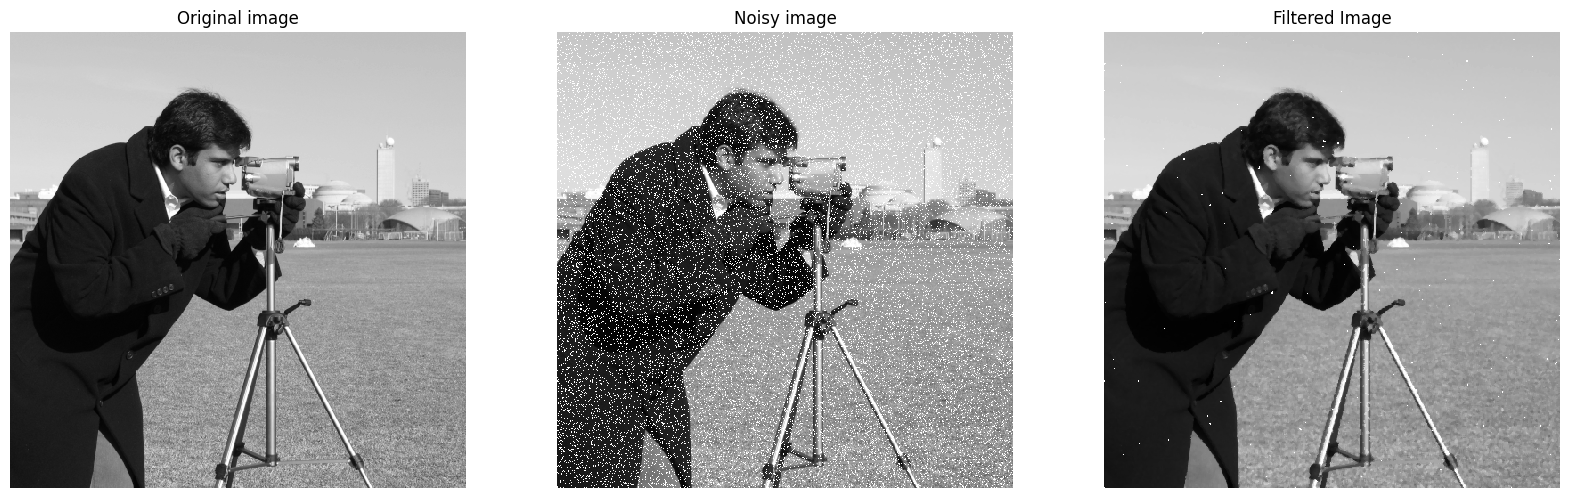

interactive(children=(IntSlider(value=3, continuous_update=False, description='Filter Size', max=15, min=3, st…

In [9]:

def median_filter_demo(original_image,filter_size=5,noise_percent=10):
    noise=np.random.rand(*original_image.shape)
    noisy_image=original_image.copy()
    noisy_image[noise>(1-noise_percent*.01)]=1.0
    median_filtered_image=scipy.ndimage.median_filter(noisy_image, 
                    size=filter_size, footprint=None, output=None, mode='reflect', cval=0.0, origin=0)
    fig1, axes_array = plt.subplots(1, 3)
    fig1.set_size_inches(20,8)
    image_plot = axes_array[0].imshow(original_image ,cmap=plt.cm.gray) # Show the original image
    axes_array[0].axis('off')
    axes_array[0].set(title='Original image')
    image_plot = axes_array[1].imshow(noisy_image,cmap=plt.cm.gray) # Show the filtered image
    axes_array[1].axis('off')
    axes_array[1].set(title='Noisy image')
    image_plot = axes_array[2].imshow(median_filtered_image,cmap=plt.cm.gray) # Show the sharpened image
    axes_array[2].axis('off')
    axes_array[2].set(title='Filtered Image')
    plt.show()
    return
current_image = data.camera()/255.
#current_image=current_image[200:220,200:220]
interact(median_filter_demo,original_image=fixed(current_image),
         filter_size=IntSlider(min=3, max=15, step=2,continuous_update=False,description='Filter Size'),
         noise_percent=IntSlider(min=0, max=100, step=1,value=10,continuous_update=False,description='Noise %'));

Notebook Courtesy: Farhad Kamangar, CSE@UTA